## Import required packages

In [101]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

## Login to Huggingface Hub 
To push the trained model to your Hugging Face Hub

In [102]:
from huggingface_hub import notebook_login
notebook_login()

## Get device

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


## Load and Explore dataset

In [104]:
dataset_name = "tanquangduong/emotion-balanced"
dataset = load_dataset(dataset_name)
num_labels = 4
labels = dataset["train"].features["label"].names

Generating train split:   0%|          | 0/6644 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1424 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1424 [00:00<?, ? examples/s]

In [105]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6644
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1424
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1424
    })
})

In [106]:
dataset['train'][100]

{'text': 'i feel as though i cant bear the motion of quilting it even though the idea of it delighted me so only a few days ago',
 'label': 1}

In [107]:
dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 6644
})

In [108]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'anger', 'fear'], id=None)}

In [109]:
dataset['train'].features['label']

ClassLabel(names=['sadness', 'joy', 'anger', 'fear'], id=None)

In [110]:
dataset['train'].features['text']

Value(dtype='string', id=None)

In [111]:
type(dataset['train'].features)

datasets.features.features.Features

In [112]:
dataset['train'][0]['label']

3

In [113]:
dataset['train']['label']

[3,
 0,
 0,
 1,
 0,
 3,
 1,
 1,
 1,
 0,
 3,
 1,
 2,
 1,
 0,
 3,
 2,
 1,
 1,
 3,
 3,
 0,
 1,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 3,
 1,
 0,
 2,
 2,
 1,
 0,
 3,
 1,
 0,
 1,
 0,
 2,
 0,
 3,
 2,
 2,
 3,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 3,
 3,
 3,
 1,
 2,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 1,
 1,
 3,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 3,
 0,
 3,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 3,
 0,
 3,
 2,
 3,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 0,
 2,
 2,
 0,
 3,
 3,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 0,
 3,
 0,
 0,
 2,
 3,
 3,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 3,
 0,
 1,
 1,
 2,
 0,
 1,
 0,
 3,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 1,
 1,
 3,
 1,
 2,
 3,
 2,
 2,
 1,
 0,
 3,
 3,
 0,
 3,
 0,
 0,
 0,
 2,
 3,
 3,
 3,
 2,
 0,
 3,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 3,
 3,
 2,
 3,
 1,
 3,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 0,
 0,
 3,
 2,
 0,
 0,
 3,
 2,
 3,
 3,
 0,
 1,
 0,
 1,
 3,
 0,
 3,
 1,
 2,
 0,
 3,
 3,
 3,
 0,
 3,
 0,
 1,
 0,
 0,
 0,
 1,
 3,
 0,
 1,
 2,
 0,
 0,
 1,
 3,
 1,
 3,
 2,
 1,
 3,
 3,
 3,


In [114]:
dataset['train'][0]['text']

'i see momo feel shy momo hmmm gt me heyy momo'

### Transform dataset to dataframe

In [115]:
dataset.set_format(type="pandas")
df = dataset["train"][:]
df.head()

,text,label
0,i see momo feel shy momo hmmm gt me heyy momo,3
1,ive been feeling really shitty lately,0
2,i feel messy and out there,0
3,i just need to find ways to feel pretty,1
4,i dont know why but every time i feel like i a...,0


### Convert label

In [116]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i see momo feel shy momo hmmm gt me heyy momo,3,fear
1,ive been feeling really shitty lately,0,sadness
2,i feel messy and out there,0,sadness
3,i just need to find ways to feel pretty,1,joy
4,i dont know why but every time i feel like i a...,0,sadness


### EDA: Label distribution

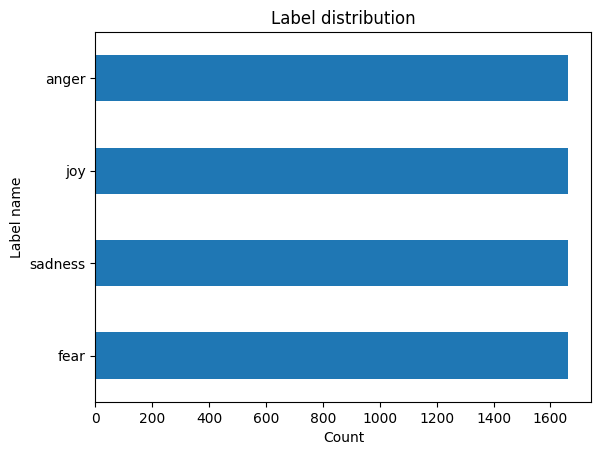

In [117]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Label distribution")
plt.ylabel("Label name")
plt.xlabel("Count")
plt.show()

### EDA: Sweet length per label

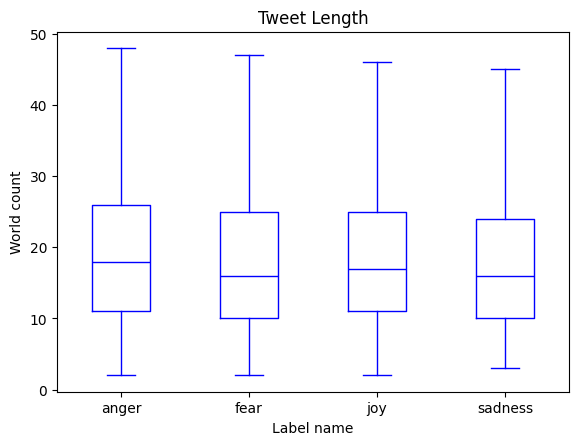

In [118]:
df["Tweet Length"] = df["text"].str.split().apply(len)
df.boxplot("Tweet Length", by="label_name", grid=False, showfliers=False,
           color="blue")
plt.suptitle("")
plt.xlabel("Label name")
plt.ylabel("World count")
plt.show()

### Reset dataset format

In [119]:
dataset.reset_format()

## Load tokenizer, model

In [120]:
pretrained_model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name,
    num_labels=num_labels,
).to(device)

## Tokenize - Encoding text to numerical representation

In [121]:
# tokenizing text batch
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
    
encoded_dataset = dataset.map(tokenize, batched=True, batch_size=None)
encoded_dataset.set_format(
    "torch", columns=["input_ids", "attention_mask", "label"]
)

Map:   0%|          | 0/6644 [00:00<?, ? examples/s]

Map:   0%|          | 0/1424 [00:00<?, ? examples/s]

Map:   0%|          | 0/1424 [00:00<?, ? examples/s]

In [122]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 6644
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1424
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1424
    })
})

## Train functions

In [123]:
config = {
    "BATCH_SIZE": 64,
    "NUM_TRAIN_EPOCHS": 2,
    "LEARNING_RATE": 2e-5,
    "WEIGHT_DECAY": 0.01,
    "DISABLE_TQDM": False,
    "PUSH_TO_HUB": False,
    "EVALUATION_STRATEGY": "epoch",
    "LOG_LEVEL": "error",
    "OUTPUT_DIR": "./models"
}

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Train
def train(config, encoded_dataset):
    logging_steps = len(encoded_dataset["train"]) // config["BATCH_SIZE"]
    DATASET_NAME = dataset_name.split('/')[-1]
    model_name = f"{pretrained_model_name}-finetuned-{DATASET_NAME}"
    output_dir = os.path.join(config["OUTPUT_DIR"], model_name) 
    
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config["NUM_TRAIN_EPOCHS"],
        learning_rate=config["LEARNING_RATE"],
        per_device_train_batch_size=config["BATCH_SIZE"],
        per_device_eval_batch_size=config["BATCH_SIZE"],
        weight_decay=config["WEIGHT_DECAY"],
        evaluation_strategy=config["EVALUATION_STRATEGY"],
        disable_tqdm=config["DISABLE_TQDM"],
        logging_steps=logging_steps,
        push_to_hub=config["PUSH_TO_HUB"],
        log_level=config["LOG_LEVEL"],
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=encoded_dataset["train"],
        eval_dataset=encoded_dataset["validation"],
        tokenizer=tokenizer,
    )
    
    trainer.train()
    
    return trainer

# Training

In [124]:
trainer = train(config, encoded_dataset)

C:\Users\easyb\Anaconda3\envs\transformer\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.974800,0.440495,0.890449,0.890505
2,0.361200,0.282320,0.926966,0.927242


## Inference

In [125]:
preds_output = trainer.predict(encoded_dataset["test"])
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(encoded_dataset["test"]["label"])    

In [126]:
preds_output.predictions

array([[ 1.0183706 , -2.362526  ,  0.55773646,  0.4023924 ],
       [ 2.5163512 , -0.8227417 , -0.6418402 , -0.6990574 ],
       [ 2.753898  , -1.2627716 , -0.6053091 , -0.6295677 ],
       ...,
       [-1.2226304 , -1.2388179 , -0.47238827,  2.3987014 ],
       [-0.9614014 , -1.105935  , -0.98771095,  2.531437  ],
       [-1.0112114 ,  2.8808222 , -0.827881  , -0.85316765]],
      dtype=float32)

In [127]:
y_preds

array([0, 0, 0, ..., 3, 3, 1], dtype=int64)

## Evaluation

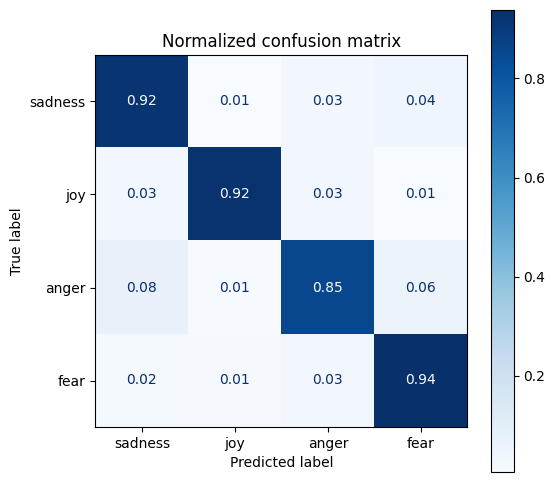

In [128]:
DATASET_NAME = dataset_name.split('/')[-1]
model_name = f"{pretrained_model_name}-finetuned-{DATASET_NAME}"
# plot confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
    plt.title("Normalized confusion matrix")
    return fig

fig = plot_confusion_matrix(y_preds, y_valid, labels)
fig.savefig(f'output/{model_name}.png')

## Push the model to Hub

In [129]:
trainer.push_to_hub(f"tanquangduong/{model_name}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

events.out.tfevents.1717426631.DESKTOP-FR2HOOJ.17312.1:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tanquangduong/distilbert-base-uncased-finetuned-emotion-balanced/commit/34c6434fa0ead659f860a985c1f7fd7e8d08967a', commit_message='tanquangduong/distilbert-base-uncased-finetuned-emotion-balanced', commit_description='', oid='34c6434fa0ead659f860a985c1f7fd7e8d08967a', pr_url=None, pr_revision=None, pr_num=None)